In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "/content/drive/path/input_file_name.zip" -d "/content/drive/path/output_folder/"

unzip:  cannot find or open /content/drive/path/input_file_name.zip, /content/drive/path/input_file_name.zip.zip or /content/drive/path/input_file_name.zip.ZIP.


In [ ]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-6393cbx7
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-6393cbx7
  Running command git submodule update --init --recursive -q


In [ ]:
!pip install tensorflow

     |████████████████████████████████| 462 kB 4.3 MB/s 


In [ ]:
pip install Keras-Applications

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from glob import glob # Navegar sobre repositórios
import cv2
import os
from google.colab.patches import cv2_imshow
import numpy as np
from sys import stdout
from classification_models.models.resnet import ResNet18, preprocess_input
import tensorflow as tf
import keras
from tensorflow.keras.layers import Dense, GlobalAvgPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
import keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping




# Definir o caminho onde o dataset se encontra
base_path = '/content/drive/MyDrive/WBC_C-SVM/Dataset/PBC_dataset_normal_DIB'



def images2matrix(folder, shape):
  
    print(folder, len(os.listdir(folder)))
    data = np.zeros(shape[0] * shape[1] * shape[2],)
    for im_name in os.listdir(folder):
        imr = cv2.imread(folder + '/' + im_name)
        if imr is None:
          print(im_name)
          continue
        resz = cv2.resize(imr, shape[:2], interpolation = cv2.INTER_AREA)   
        data = np.vstack([data, resz.flatten()])

    return data

img_width, img_height = 32, 32
img_shape = (32,32,3)
#img_width, img_height = 360, 363

In [ ]:
#dataset = tf.keras.utils.image_dataset_from_directory(base_path, image_size=(img_height, img_width), batch_size=17149, seed=42)

In [ ]:
#images, labels = dataset.take(1)

In [ ]:
#images, labels = next(iter(dataset))

In [ ]:
images_basophil = images2matrix(base_path + "/basophil", img_shape)
images_eosinophil = images2matrix(base_path + "/eosinophil", img_shape)
images_erythroblast = images2matrix(base_path + "/erythroblast", img_shape)
images_ig = images2matrix(base_path + "/ig", img_shape)
images_lymphocyte = images2matrix(base_path + "/lymphocyte", img_shape)
images_monocyte = images2matrix(base_path + "/monocyte", img_shape)
images_neutrophil = images2matrix(base_path + "/neutrophil", img_shape)

/content/drive/MyDrive/WBC_C-SVM/Dataset/PBC_dataset_normal_DIB/basophil 1218
/content/drive/MyDrive/WBC_C-SVM/Dataset/PBC_dataset_normal_DIB/eosinophil 3117
/content/drive/MyDrive/WBC_C-SVM/Dataset/PBC_dataset_normal_DIB/erythroblast 1551
/content/drive/MyDrive/WBC_C-SVM/Dataset/PBC_dataset_normal_DIB/ig 2895
/content/drive/MyDrive/WBC_C-SVM/Dataset/PBC_dataset_normal_DIB/lymphocyte 1214
/content/drive/MyDrive/WBC_C-SVM/Dataset/PBC_dataset_normal_DIB/monocyte 1420
/content/drive/MyDrive/WBC_C-SVM/Dataset/PBC_dataset_normal_DIB/neutrophil 3330


error: ignored

In [ ]:
images_basophil.shape

(1219, 3072)

In [ ]:
list_img = [images_basophil, images_eosinophil, images_erythroblast, images_ig, images_lymphocyte, images_monocyte, images_neutrophil]
images = np.concatenate(list_img, axis=0)#.reshape((-1, *img_shape))

In [ ]:
images.shape

(14751, 3072)

In [ ]:
labels = np.array(
    [0]*len(images_basophil) + 
    [1]*len(images_eosinophil) + 
    [2]*len(images_erythroblast) + 
    [3]*len(images_ig) + 
    [4]*len(images_lymphocyte) + 
    [5]*len(images_monocyte) + 
    [6]*len(images_neutrophil)
)

In [ ]:
labels.shape

(14751,)

In [ ]:
labels

array(['basophil', 'basophil', 'basophil', ..., 'neutrophil',
       'neutrophil', 'neutrophil'], dtype='<U12')

In [ ]:
np.unique(labels, return_counts=True)

(array(['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte',
        'monocyte', 'neutrophil'], dtype='<U12'),
 array([1219, 3118, 1552, 2896, 1215, 1421, 3330]))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.3, random_state=42, stratify=labels) #test_size pode mudar
X_train = X_train.reshape((-1, *img_shape))/255
X_test = X_test.reshape((-1, *img_shape))/255

In [ ]:
X_train.shape

(10325, 32, 32, 3)

In [ ]:
base_model = ResNet18(input_shape=img_shape, include_top=False, weights="imagenet", backend=K, layers=tf.keras.layers, models=tf.keras.models, utils=tf.keras.utils)
X = GlobalAvgPool2D(name="Global")(base_model.output) # A saída da ResNet com inclus_top=False é uma imagem, GAP2D vai calcular a media por cada canal
output = Dense(7, activation = "softmax")(X) # Faz a classificação

model = Model(inputs=base_model.inputs, outputs=[output])
model.summary() # Faz a tabela

list_callbacks = [
  EarlyStopping(monitor="val_accuracy", patience=10, verbose=1, restore_best_weights=True)
]

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test), verbose=1, callbacks=list_callbacks) 

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 bn_data (BatchNormalization)   (None, 32, 32, 3)    9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_144 (ZeroPaddin  (None, 38, 38, 3)   0           ['bn_data[0][0]']                
 g2D)                                                                                             
                                                                                                  
 conv0 (Conv2D)                 (None, 16, 16, 64)   9408        ['zero_padding2d_144[0][0]

In [ ]:
model_ResNet = Model(inputs=model.inputs, outputs=[model.get_layer("Global").output])
model_ResNet.summary()

Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 bn_data (BatchNormalization)   (None, 32, 32, 3)    9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d_144 (ZeroPaddin  (None, 38, 38, 3)   0           ['bn_data[0][0]']                
 g2D)                                                                                             
                                                                                                  
 conv0 (Conv2D)                 (None, 16, 16, 64)   9408        ['zero_padding2d_144[0][0]

In [ ]:
X_train_ResNet = model_ResNet.predict(X_train)
X_test_ResNet = model_ResNet.predict(X_test)

In [ ]:
X_test_ResNet.shape, X_test.shape

((4426, 512), (4426, 32, 32, 3))

In [ ]:
clf = SVC(C=10)
clf.fit(X_train_ResNet, y_train)
y_pred = clf.predict(X_test_ResNet)

In [ ]:
accuracy_score(y_test, y_pred) # Sem treinar a ResNet antes -> 0.7040216900135563

0.9396746497966562

In [ ]:
precision_score(y_test, y_pred, average="macro")

0.9335568247980967

In [ ]:
recall_score(y_test, y_pred, average="macro")

0.9318769708171947

In [ ]:
f1_score(y_test, y_pred, average="macro")

0.9326783680661146

In [ ]:
lista_labels = ["basophil", "eosinophil", "erythroblast", "ig", "lymphocyte", "monocyte", "neutrophil"]

In [ ]:
confusion_matrix(y_test, y_pred)

array([[333,   0,   0,  27,   2,   3,   1],
       [  1, 930,   0,   1,   0,   0,   3],
       [  0,   0, 437,  10,  13,   2,   4],
       [ 22,   1,   9, 775,   5,  36,  21],
       [  2,   0,   6,  12, 338,   6,   1],
       [  4,   0,   0,  32,   5, 383,   2],
       [  3,   3,   2,  27,   0,   1, 963]])

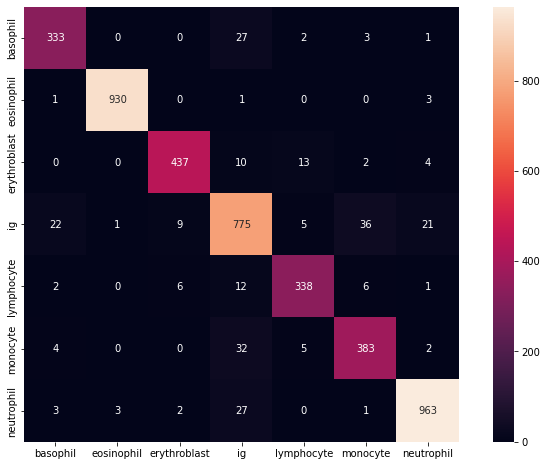

In [ ]:
import seaborn as sns
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), xticklabels=lista_labels, yticklabels=lista_labels, annot=True, fmt="d", square=True)